# Regression

In [1]:
### --- Dependencies --- ###
import importlib
from definitions import *
import torch
import argparse
from tqdm import tqdm
import datetime


# parser = argparse.ArgumentParser(description='PyTorch NTK Uncertainty Estimate Experiment')
# parser.add_argument('--dataset',default='cifar',type=str,help='dataset (cifar or imagenet)')
# args = parser.parse_args()

### --- CONSTANTS --- ###
dataset_str = 'concrete'
TRAIN_RATIO = 0.9
BATCH_SIZE = 100
NORMALIZE_X = True
NORMALIZE_Y = True
LAYER_WIDTH = 150
NTK_WEIGHT_INIT = True

NTK_MODEL_PATH = "./model_chkpt/ntk_network.pt"
ENSEMBLE_MODEL_PATH = "./model_chkpt/ensemble_networks.pt"

learning_rate = 1e-2
epochs = 400

ensemble_M = 5

FIND_MAN_KAPPA = False
REPORT_KAPPA = False
FIND_FUNC_JAX_KAPPA = True
KAPPA_COMPARISON = FIND_MAN_KAPPA and FIND_FUNC_JAX_KAPPA

type_solve = 'iterative'
rtol_solve = 1e-10
maxit_solve = 1000

### --- INPUT DATA HERE AS WELL AS DATASET NAME --- ###
if dataset_str == 'energy':
    df = pd.read_excel('.\data\Energy\ENB2012_data.xlsx')
    num_features = 8
elif dataset_str == 'concrete':
    df = pd.read_excel('.\data\Concrete\Concrete_Data.xls')
    num_features = 8

# print(data.shape)
print("--- Loading dataset {} --- \n".format(dataset_str))
print("Number of data points = {}".format(len(df)))
print("Number of coloumns = {}".format(len(df.columns)))
print("Number of features = {}".format(num_features))

training_set, test_set = data_split(df,TRAIN_RATIO)

if NORMALIZE_X:
    train_mX = training_set[:,:num_features].mean(axis=0)
    train_sX = training_set[:,:num_features].std(axis=0)
    train_sX[train_sX==0]=1
else:
    train_mX = 0
    train_sX = 1

if NORMALIZE_Y:
    train_my = training_set[:,num_features].mean(axis=0)
    train_sy = training_set[:,num_features].std(axis=0)
    if train_sy==0:
        train_sy=1
else:
    train_my = 0
    train_sy = 1

train_dataset = RegressionDataset(training_set, input_dim=num_features, mX=train_mX, sX=train_sX, my=train_my, sy=train_sy)
test_dataset = RegressionDataset(test_set, input_dim=num_features, mX=train_mX, sX=train_sX)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_set), shuffle=False)

np.set_printoptions(suppress=True, precision=3)
print("\n Sample training point \n X: {}, \n y: {} \n".format(train_dataset.__getitem__(0)[0], train_dataset.__getitem__(0)[1]))
print("Sample test point \n X: {}, \n y: {} ".format(test_dataset.__getitem__(0)[0], test_dataset.__getitem__(0)[1]))

--- Loading dataset concrete --- 

Number of data points = 1030
Number of coloumns = 9
Number of features = 8
training set has shape (927, 9) 

test set has shape (103, 9)

 Sample training point 
 X: tensor([-0.2836, -0.8580,  0.9975,  0.3093, -0.0652,  0.7160, -0.1860, -0.4879]), 
 y: -0.33939426127894434 

Sample test point 
 X: tensor([-0.6446, -0.8580,  1.8722, -1.0467,  0.9316,  0.9110, -0.0108, -0.4879]), 
 y: 29.592309919999998 


In [3]:
## Create Model
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

ntk_network = MLP(input_d=num_features,width=LAYER_WIDTH).to(device=device, dtype=torch.float64)
if NTK_WEIGHT_INIT:
    ntk_network.apply(weights_init)
print("Number of parameters in NTK network = {}".format(sum(p.numel() for p in ntk_network.parameters() if p.requires_grad)))

## Train NTK network
mse_loss = nn.MSELoss(reduction='mean')
ntk_optimizer = optimizer_shared(ntk_network, type='adam', learning_rate=learning_rate)

# Run the training loop
print("\n Training NTK network \n")
for epoch in tqdm(range(epochs)):
    ntk_train_mse  = training_loop_ntk(
        dataloader=train_loader,
        model=ntk_network, 
        optimizer=ntk_optimizer,
        loss_function=mse_loss,
        verbose=False)
    
    ntk_test_mse, ntk_test_rel_error = test_loop_ntk(
        dataloader=test_loader,
        model = ntk_network,
        my=train_my,
        sy=train_sy,
        loss_function=mse_loss)
    
# Process is complete.
print('\n NTK Training process has finished.')
print("Final training MSE = {:.3f}".format(ntk_train_mse))
print("Final test MSE = {:.2f}".format(ntk_test_mse))

torch.save({
    'model': ntk_network.state_dict(),
    'train_mse': ntk_train_mse,
    'test_mse': ntk_test_mse,
    'test_rel_err': ntk_test_rel_error
    },
    NTK_MODEL_PATH)

## 
ensemble_model_list = []
ensemble_model_state_list = []
ensemble_opt_list = []
ensemble_mse_training_list = np.empty(ensemble_M)
ensemble_mse_test_list = np.empty(ensemble_M)
ensemble_nll_list = np.empty(ensemble_M)
ensemble_rel_err_test_list = np.empty((ensemble_M,len(test_dataset)))

NLL = CustomNLL()
for i in range(ensemble_M):
    ensemble_model_list.append(EnsembleNetwork(input_d=num_features, width=LAYER_WIDTH).to(device=device,dtype=torch.float64))
    ensemble_opt_list.append(optimizer_shared(ensemble_model_list[i], type='adam', learning_rate=learning_rate))

for i in range(ensemble_M):
    print(f"\n Training ensemble {i+1} ")
    for t in tqdm(range(epochs)):
        ensemble_train_mse = training_loop_ensemble(
            dataloader=train_loader, 
            model=ensemble_model_list[i], 
            optimizer=ensemble_opt_list[i], 
            loss_function=NLL,
            mse_loss= mse_loss,
            verbose=False)
        ensemble_test_mse, ensemble_test_nll, ensemble_test_rel_err = test_loop_ensemble(
            dataloader=test_loader, 
            model=ensemble_model_list[i], 
            my=train_my, 
            sy=train_sy, 
            mse_loss=mse_loss,
            loss_function=NLL)
    print("Done!")
    ensemble_mse_training_list[i] = ensemble_train_mse
    ensemble_mse_test_list[i] = ensemble_test_mse
    ensemble_nll_list[i] = ensemble_test_nll
    ensemble_rel_err_test_list[i,:] = ensemble_test_rel_err.detach().numpy().squeeze(1)
print('\n Ensemble training process has finished.')

## Print training metrics
print("Final ntk training MSE = {:.3f}".format(ntk_train_mse))
print("Final ntk test MSE = {:.2f}".format(ntk_test_mse))
print("Final ensemble training MSE = {}".format(ensemble_mse_training_list))
print("Final ensemble test MSE = {}".format(ensemble_mse_test_list))

for i in range(ensemble_M):
    ensemble_model_state_list.append(ensemble_model_list[i].state_dict())

torch.save({
    'models': ensemble_model_state_list,
    'train_mse': ensemble_mse_training_list,
    'test_mse': ensemble_mse_test_list,
    'test_nll': ensemble_nll_list,
    'test_rel_err': ensemble_rel_err_test_list
    },
    ENSEMBLE_MODEL_PATH)

print("Model saved!")

Using cpu device
Number of parameters in NTK network = 24151

 Training NTK network 



100%|██████████| 400/400 [00:07<00:00, 53.89it/s]



 NTK Training process has finished.
Final training MSE = 0.021
Final test MSE = 40.23

 Training ensemble 1 


100%|██████████| 400/400 [00:08<00:00, 45.95it/s]


Done!

 Training ensemble 2 


100%|██████████| 400/400 [00:09<00:00, 42.20it/s]


Done!

 Training ensemble 3 


100%|██████████| 400/400 [00:09<00:00, 42.92it/s]


Done!

 Training ensemble 4 


100%|██████████| 400/400 [00:09<00:00, 43.75it/s]


Done!

 Training ensemble 5 


100%|██████████| 400/400 [00:08<00:00, 45.20it/s]

Done!

 Ensemble training process has finished.
Final ntk training MSE = 0.021
Final ntk test MSE = 40.23
Final ensemble training MSE = [0.018 0.023 0.022 0.029 0.019]
Final ensemble test MSE = [36.803 32.568 32.555 27.264 37.019]
Model saved!


Loading models:
Models loaded.


C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version o


 --- Finding uncertainty estimates --- 



100%|██████████| 103/103 [00:19<00:00,  5.23it/s]


Finished! 

Number of zero values uncertainty array: 0
Number of negative values for full rank: 0

 --- Plotting Results --- 



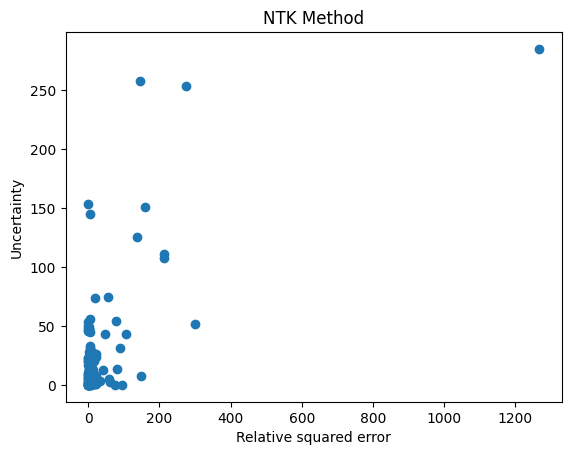

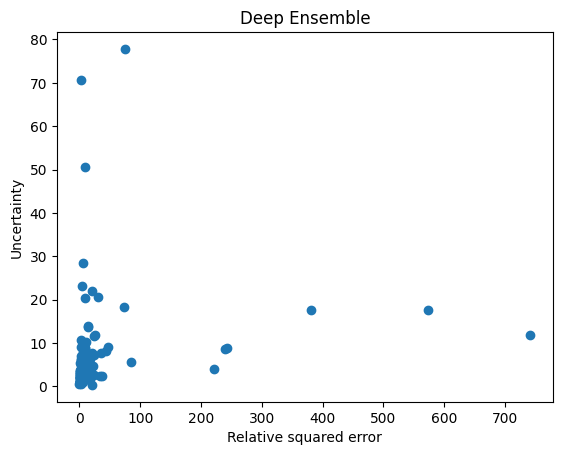

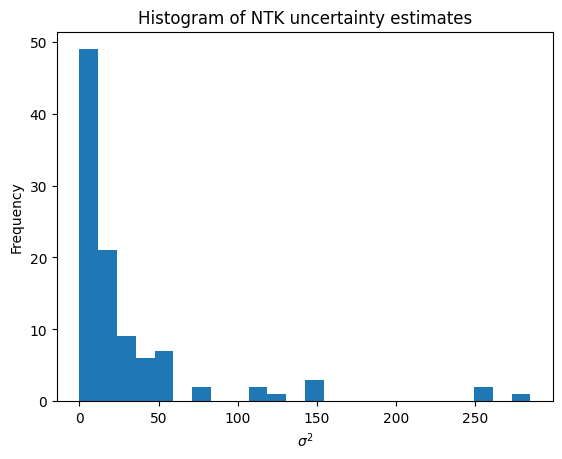

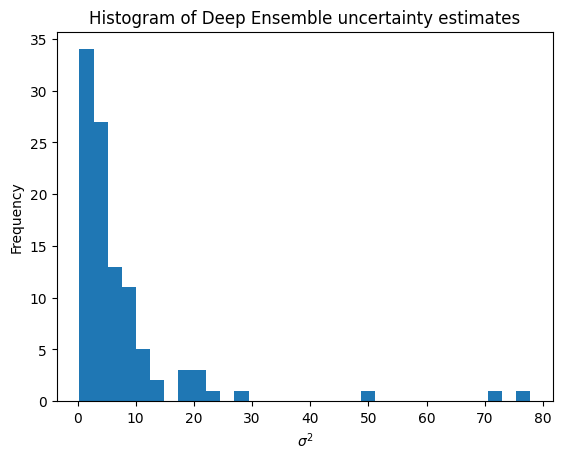

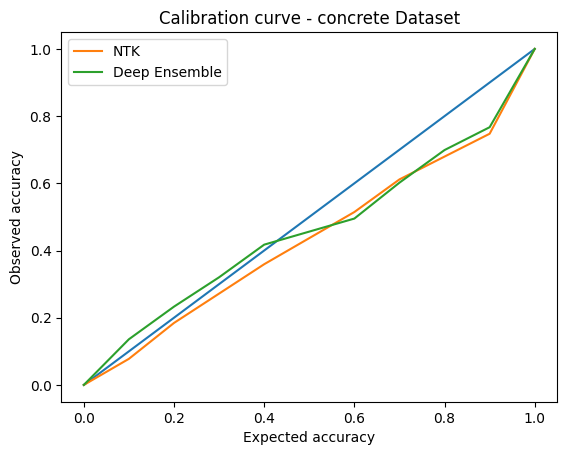

Final ntk training MSE = 0.021
Final ntk test MSE = 40.23
Final ensemble training MSE = [0.018 0.023 0.022 0.029 0.019]
Final ensemble test MSE = [36.803 32.568 32.555 27.264 37.019]


In [4]:
## load models
print("Loading models:")

# Load NTK Model
ntk_saved_model = torch.load(NTK_MODEL_PATH)

ntk_network = MLP(input_d=num_features,width=LAYER_WIDTH).to(device=device, dtype=torch.float64)
ntk_network.load_state_dict(ntk_saved_model['model'])
ntk_network.eval()

ntk_train_mse = ntk_saved_model['train_mse']
ntk_test_mse = ntk_saved_model['test_mse']
ntk_test_rel_error = ntk_saved_model['test_rel_err']

# Load Ensemble Models
ensemble_saved_models = torch.load(ENSEMBLE_MODEL_PATH)

ensemble_model_list = []
for i in range(ensemble_M):
    ensemble_model_list.append(EnsembleNetwork(input_d=num_features, width=LAYER_WIDTH).to(device=device,dtype=torch.float64))
    ensemble_model_list[i].load_state_dict(ensemble_saved_models['models'][i])
    ensemble_model_list[i].eval()

ensemble_mse_training_list = ensemble_saved_models['train_mse']
ensemble_mse_test_list = ensemble_saved_models['test_mse']
ensemble_nll_list = ensemble_saved_models['test_nll']
ensemble_rel_err_test_list = ensemble_saved_models['test_rel_err']

print("Models loaded.")

### --- NTK --- ###
if FIND_MAN_KAPPA:
    EPSILON = 0
    print("\n --- Finding Kappa --- \n")
    kappa_man_time_start = time.time()
    Kappa_man = ntk_matrix(train_dataset,train_dataset,model=ntk_network,optimizer=ntk_optimizer)
    kappa_man_time_end = time.time()
    kappa_man_time = kappa_man_time_end - kappa_man_time_start
    eigvals = np.linalg.eigvalsh(Kappa_man)

if FIND_FUNC_JAX_KAPPA:
    kappa_jax_time_start = time.time()
    Kappa = empirical_ntk(
        model=ntk_network,
        dataset1=train_dataset,
        dataset2=train_dataset
    )
    Kappa_jax = Kappa.detach().numpy().squeeze((2,3))
    kappa_jax_time_end = time.time()
    kappa_jax_time = kappa_jax_time_end - kappa_jax_time_start
    eigvals = np.linalg.eigvalsh(Kappa_jax)

if REPORT_KAPPA:
    print("\n--- Kappa (Manual) Summary --- \n")
    print("Condition number of Kappa = {:.2f}".format(np.linalg.cond(Kappa)))
    eigvals = np.linalg.eigvalsh(Kappa)
    print("Number of negative eigenvalues of Kappa = {}".format(eigvals[eigvals<0].size))
    print("Number of zero eigenvalues of Kappa = {}".format(eigvals[eigvals==0].size))
    print("Smallest eigenvalue is = {}".format(sorted(eigvals)[0]))

if KAPPA_COMPARISON:

    man_eigvals = np.linalg.eigvalsh(Kappa_man)
    jax_eigvals = np.linalg.eigvalsh(Kappa_jax)

    plot_dir = "./ntk_conditioning_results/"
    results_name = "results.txt"
    with open(plot_dir+results_name,'w') as results:
        results.write("{} \n".format(datetime.datetime.now()))
        results.write("Manual method: \n\
                    Method time elapsed = {} seconds\n \
                    Condition number = {}, \n\
                    Num negative eigvals = {} \n\
                    Smallest eigval = {}. \n".format(kappa_man_time,
                                                     np.linalg.cond(Kappa_man),
                                                        man_eigvals[man_eigvals<0].size,
                                                        sorted(man_eigvals)[0])
        )
        results.write("\n PyTorch JAX method: \n\
                    Method time elapsed = {} seconds\n \
                    Condition number = {} \n\
                    Num negative eigvals = {} \n\
                    Smallest eigval = {}. \n".format(kappa_jax_time,
                                                     np.linalg.cond(Kappa_jax),
                                                        jax_eigvals[jax_eigvals<0].size,
                                                        sorted(jax_eigvals)[0])
        )
        results.write("Frobenius norm difference between two methods = {}".format(
            np.linalg.norm(Kappa_man-Kappa_jax)
        ))

### --- Current Kappa --- ###
        
Kappa = Kappa_jax

## Uncertainty Quantification
print("\n --- Finding uncertainty estimates --- \n")
uncert_time_start = time.time()
uncertainty_array, solver_info = ntk_uncertainty_explicit(
    Kappa=Kappa, 
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model=ntk_network,
    optimizer=ntk_optimizer,
    type=type_solve,
    rtol=rtol_solve,
    maxit=maxit_solve)
uncert_time_end = time.time()
uncert_time = uncert_time_end-uncert_time_start # (seconds)
solver_info_mean = np.mean(solver_info,axis=1)
print("Finished! \n")
print("Number of zero values uncertainty array: {}".format(uncertainty_array[uncertainty_array==0].size))
print("Number of negative values for full rank: {}".format(uncertainty_array[uncertainty_array<0].size))

mu_mean, sigma_mean = ensemble_result(
    test_loader=test_loader,
    ensemble_M=ensemble_M,
    model_list=ensemble_model_list,
    sy=train_sy,
    my=train_my
)
ensemble_rel_err_test_list = np.mean(ensemble_rel_err_test_list,axis=0)

### --- Plot results --- ###
print("\n --- Plotting Results --- \n")
today = datetime.date.today()
now = datetime.datetime.now()
# plot_dir = "./data/{}/{}/plot/".format(dataset_str, today.strftime("%d_%m_%Y"))
plot_dir = "./data/{}/{}/plot/".format(dataset_str, now.strftime("%d_%m_%Y__%H_%M_%S"))
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

## NTK Scatter
plot_name = "ntk_scatter.pdf"
plt.scatter(ntk_test_rel_error, uncertainty_array*(train_sy**2))
plt.xlabel("Relative squared error")
plt.ylabel("Uncertainty")
plt.title("NTK Method")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

## Deep Ensemble scatter
plot_name = "ensemble_scatter.pdf"
plt.scatter(ensemble_rel_err_test_list, sigma_mean)
plt.xlabel("Relative squared error")
plt.ylabel("Uncertainty")
plt.title("Deep Ensemble")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

## NTK Histogram
plot_name = "ntk_hist.pdf"
plt.hist(sorted((train_sy**2)*uncertainty_array.squeeze(0)), bins='auto')
plt.xlabel("$\sigma^2$")
plt.ylabel("Frequency")
plt.title("Histogram of NTK uncertainty estimates")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

## Deep Ensemble Histogram
plot_name = "ensemble_hist.pdf"
plt.hist(sorted(sigma_mean), bins='auto')
plt.xlabel("$\sigma^2$")
plt.ylabel("Frequency")
plt.title("Histogram of Deep Ensemble uncertainty estimates")
plt.savefig(plot_dir + plot_name.format(dataset_str), format="pdf", bbox_inches="tight")
plt.show()

### --- Plot calibration curve --- ###

plot_name = "calibration_curve.pdf"
observed_true_ntk = calibration_curve_ntk(
    testloader=test_loader, 
    uncertainties=uncertainty_array, 
    model=ntk_network, 
    num_c=11, 
    my=train_my, 
    sy=train_sy)
observed_true_ensemble = calibration_curve_ensemble(
    testloader=test_loader, 
    mu=mu_mean, 
    sigma2=sigma_mean, 
    num_c=11)
plot_calibration(
    observed_true_ntk=observed_true_ntk, 
    observed_true_ensemble=observed_true_ensemble, 
    dataset_str=dataset_str, 
    dir_name=plot_dir, 
    plot_name=plot_name)

result_dir = "./data/{}/{}/result/".format(dataset_str, now.strftime("%d_%m_%Y__%H_%M_%S"))
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)

print("Final ntk training MSE = {:.3f}".format(ntk_train_mse))
print("Final ntk test MSE = {:.2f}".format(ntk_test_mse))
print("Final ensemble training MSE = {}".format(ensemble_mse_training_list))
print("Final ensemble test MSE = {}".format(ensemble_mse_test_list))

results_name = "results.txt"
with open(result_dir+results_name,'w') as results:
    results.write("--- Dataset & Model --- \n")
    results.write("Number of training points = {} \n".format(len(training_set)))
    results.write("Number of test points = {} \n".format(len(test_set)))
    results.write("Number of features = {} \n".format(num_features))
    results.write("Number of hidden layers = {} \n".format(1))
    results.write("Width of hidden layer = {} \n".format(LAYER_WIDTH))
    results.write("Number of parameters in NTK network = {} \n".format(
        sum(p.numel() for p in ntk_network.parameters() if p.requires_grad)))

    results.write("\n --- Results --- \n")
    results.write("Final ntk training mse = {:.3f} \n".format(ntk_train_mse))
    results.write("Final ntk test mse = {:.2f} \n".format(ntk_test_mse))
    results.write("Deep Ensemble training mse: mean = {:.2f}, std = {:.2f} \n".format(np.mean(ensemble_mse_training_list),np.std(ensemble_mse_training_list)))
    results.write("Deep Ensemble test mse: mean = {:.2f}, std = {:.2f} \n".format(np.mean(ensemble_mse_test_list),np.std(ensemble_mse_test_list)))
    results.write("Deep Ensemble NLL: mean = {:.2f}, std {:.2f} \n".format(np.mean(ensemble_nll_list),np.std(ensemble_nll_list)))
    results.write("\n --- Training Details --- \n")
    results.write("Learning Rate = {} \n".format(learning_rate))
    results.write("Training Epochs = {} \n".format(epochs))
    results.write("Number of ensembles = {} \n".format(ensemble_M))

    results.write("\n --- NTK Method Details --- \n")
    results.write("Condition number of Kappa = {:.2f} \n".format(np.linalg.cond(Kappa)))
    results.write("Number of negative eigenvalues of Kappa = {} \n".format(eigvals[eigvals<0].size))
    results.write("Number of zero eigenvalues of Kappa = {} \n".format(eigvals[eigvals==0].size))

    results.write("\n --- Uncertainty Solution Details --- \n")
    results.write("Type of linear solver = {} \n".format(type_solve))
    if type_solve=='iterative':
        results.write("Time to solve all test examples = {:.2f} seconds \n".format(uncert_time))
        results.write("Tolerance of solver = {} \n".format(rtol_solve))
        results.write("Max iteration of solver = {} \n".format(maxit_solve))
        results.write("Average solver iter = {} \n".format(solver_info_mean[0]))
        results.write("Average solver resid error = {} \n".format(solver_info_mean[1]))
        results.write("Average solver matrix resid error = {} \n".format(solver_info_mean[2]))
    results.write("\n Number of negative values in NTK uncertainties array: {} \n".format(uncertainty_array[uncertainty_array<0].size))
    results.write("Number of zero values in NTK uncertainties array: {} \n".format(uncertainty_array[uncertainty_array==0].size))


# Classification

In [1]:
import torch
from torchvision.transforms import ToTensor
from torchvision import datasets
from tqdm import tqdm
from definitions import *

N_TRAIN = 1000
N_TEST = 100
N_OUTPUT = 10
learning_rate = 1e-1
batch_size = 50
epochs = 50

training_data = datasets.MNIST(
    root="data/MNIST",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data/MNIST",
    train=False,
    download=True,
    transform=ToTensor()
)

training_data = torch.utils.data.Subset(training_data,range(N_TRAIN))
test_data = torch.utils.data.Subset(test_data,range(N_TEST))
 
cnn = CNN()
print("Number of parameters p = {}".format(sum(p.numel() for p in cnn.parameters() if p.requires_grad)))

train_dataloader = DataLoader(training_data, batch_size)
test_dataloader = DataLoader(test_data, batch_size)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate)

for t in tqdm(range(epochs)):
    cnn_train_ce = train_loop(train_dataloader, cnn, loss_fn, optimizer)
    cnn_test_ce, cnn_test_acc = test_loop(test_dataloader, cnn, loss_fn)
print("Done!")
print("Final cnn training cross-entropy = {:.3f}".format(cnn_train_ce))
print("Final cnn test cross-entropy = {:.2f}".format(cnn_test_ce))
print("Final cnn test accuracy = {:.1f}%".format(100*cnn_test_acc))

Number of parameters p = 1301


100%|██████████| 50/50 [00:08<00:00,  5.58it/s]

Done!
Final cnn training cross-entropy = 0.008
Final cnn test cross-entropy = 0.18
Final cnn test accuracy = 93.0%


In [18]:
dataset = DataLoader(training_data,len(training_data))
x,y = next(iter(dataset))
print(x.shape)
print(y.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


In [64]:
fnet, params = make_functional(cnn)
def fnet_single(params, x):
    # x = fnet(params,x.squeeze(0))[0].unsqueeze(0)
    # print(x)
    return fnet(params, x.unsqueeze(0))[0].unsqueeze(0)
def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2):
    # Compute J(x1)
    # l = fnet_single(params,x1[0])
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]

    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]

    [print(j1.shape,j2.shape) for j1, j2 in zip(jac1,jac2)]
    
    # Compute J(x1) @ J(x2).T
    result = torch.stack([torch.einsum('Naf,Mbf->NMab', j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result
dataset = DataLoader(training_data,len(training_data))
dataset2 = DataLoader(train_dataset,len(train_dataset))
x,y = next(iter(dataset))
result = empirical_ntk_jacobian_contraction(fnet_single, params, x, x)
print(result.shape)
result = result.detach().numpy().squeeze((2,3))
print(result.shape)

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version o

torch.Size([1000, 1, 2000]) torch.Size([1000, 1, 2000])
torch.Size([1000, 1, 80]) torch.Size([1000, 1, 80])
torch.Size([1000, 1, 6000]) torch.Size([1000, 1, 6000])
torch.Size([1000, 1, 30]) torch.Size([1000, 1, 30])
torch.Size([1000, 1, 4800]) torch.Size([1000, 1, 4800])
torch.Size([1000, 1, 100]) torch.Size([1000, 1, 100])
torch.Size([1000, 1000, 1, 1])
(1000, 1000)


In [20]:
print(result.shape)

tensor([[[[ 3.8753e+03, -9.1272e+01,  2.6055e+01,  ...,  1.9698e+02,
           -2.4470e+02, -2.9861e+02],
          [-9.1272e+01,  3.3758e+03, -4.9000e+02,  ...,  3.1113e+01,
            1.8946e+02,  1.6618e+02],
          [ 2.6055e+01, -4.9000e+02,  4.2990e+03,  ..., -9.4130e+01,
           -6.7677e+02, -4.5814e+02],
          ...,
          [ 1.9698e+02,  3.1113e+01, -9.4130e+01,  ...,  3.2158e+03,
           -2.6691e+01, -8.8475e+01],
          [-2.4470e+02,  1.8946e+02, -6.7677e+02,  ..., -2.6691e+01,
            3.5981e+03,  1.6825e+02],
          [-2.9861e+02,  1.6618e+02, -4.5814e+02,  ..., -8.8475e+01,
            1.6825e+02,  3.2198e+03]],

         [[ 1.4645e+03, -3.5740e+01, -8.6450e+01,  ..., -3.7280e+02,
            1.2627e+02, -2.0731e+02],
          [ 3.8514e+02,  1.6442e+03, -6.4341e+02,  ...,  4.7970e+01,
           -3.0828e+02,  4.7329e+02],
          [-1.2352e+02, -3.4750e+02,  2.5101e+03,  ...,  3.6253e+02,
            8.2066e+01, -7.6292e+02],
          ...,
     

In [ ]:
ood_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download=True,
    transform=ToTensor()
)
ood_test_point = ood_data.__getitem__(1)
ood_uncertainty_array=ntk_uncertainty_classification_single(training_data,ood_test_point[0],model=cnn,optimizer=optimizer,num_c=10,mode='max')
test_point = test_data.__getitem__(1)[0]
uncertainty_array=ntk_uncertainty_classification_single(training_data,test_point,model=cnn,optimizer=optimizer,num_c=10,mode='max')
print(uncertainty_array)
print(ood_uncertainty_array)
print(torch.argmax(cnn(ood_test_point[0])).item())
print(ood_test_point[1])

In [2]:
uncertainty_array = ntk_uncertainty_classification(
    train_dataset=training_data,
    test_dataset=test_data,
    model=cnn,
    optimizer=optimizer,
    num_c=1,
    solve_rtol=1e-5,
    solve_maxit=40
)



0it [00:00, ?it/s]


0


  0%|          | 88/1000000 [00:00<38:04, 437.63it/s]

1


2


3


  0%|          | 3095/1000000 [00:06<36:38, 453.48it/s]

4


5


6


  1%|          | 6069/1000000 [00:13<40:09, 412.44it/s]


7


  1%|          | 7871/1000000 [00:17<37:19, 443.08it/s]
0it [00:17, ?it/s]


KeyboardInterrupt: 